In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

/Users/johannesalneberg/anaconda/envs/basic_sandbox/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_context('talk')

In [3]:
usage = pd.read_table("uppmax_data/20170105.tsv", index_col=0, names=["cluster", "jobstate", "user", 
                                                                      "project", "job_name", "endtime", 
                                                                      "runtime", "flags", "cores_booked", "mem_used", 
                                                                      "cores", "node", "jobstats"])

In [4]:
def runtime_to_minutes(runtime_s):
    if '-' in runtime_s:
        try:
            days_s, hours_s = runtime_s.split('-')
            days = int(days_s)
        except ValueError:
            print runtime_s
            raise
    else:
        days = 0
        hours_s = runtime_s
    hours, minutes, seconds = (int(x) for x in hours_s.split(':'))
    return (days*24+hours)*60 + minutes

In [6]:
usage['runtime_minutes'] = usage.runtime.apply(runtime_to_minutes)
usage['cpu_minutes'] = usage['runtime_minutes'] * usage['cores_booked']

In [7]:
minutes_stats = {}
minutes_stats['no_flags'] = usage[usage['flags'] =='.'].cpu_minutes.sum()
minutes_stats['fat_node_flag_only'] = usage[usage['flags'] == 'node_type_overbooked:mem512GB:mem256GB'].cpu_minutes.sum() + \
    usage[usage['flags'] == 'node_type_overbooked:mem512GB:mem128GB'].cpu_minutes.sum() + \
    usage[usage['flags'] == 'node_type_overbooked:mem256GB:mem128GB'].cpu_minutes.sum()
minutes_stats['other_overbooked'] = usage[usage['flags'] !='.'].cpu_minutes.sum() - minutes_stats['fat_node_flag_only']

## Proportion of efficiently running jobs
Jobs that are flagged with using a fat node, when a thin node would have worked are not considered wasteful since there is normally no less access to fat nodes than thin nodes.

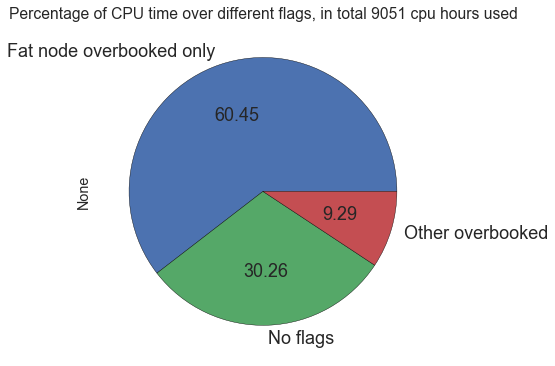

In [8]:
ax = pd.Series(minutes_stats).plot(kind='pie', figsize=(6,6), autopct='%.2f', fontsize=18, labels=["Fat node overbooked only", "No flags", "Other overbooked"])
t = ax.set_title("Percentage of CPU time over different flags, in total {} cpu hours used".format(usage.cpu_minutes.sum()/60))

In [9]:
usage_other_overbooked = usage[(usage['flags'] != '.') & ~(usage['flags'].isin(['node_type_overbooked:mem512GB:mem256GB',
                                                                                'node_type_overbooked:mem512GB:mem128GB',
                                                                                'node_type_overbooked:mem256GB:mem128GB',
                                                                                '!!swap_used']))]

## Finding the worst offending jobs
Jobs which were overbooked that used the most cpu time

In [10]:
usage_other_overbooked.sort('cpu_minutes', ascending=False).head(10)[['flags','user','job_name', 'cpu_minutes']]

/Users/johannesalneberg/anaconda/envs/basic_sandbox/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,flags,user,job_name,cpu_minutes
9273124,"overbooked:75%,node_type_overbooked:mem512GB:m...",mattiri,'KDUPP_114_129',14400
9273120,"overbooked:69%,node_type_overbooked:mem512GB:m...",mattiri,'KDUPP_50_65',12448
9273118,"overbooked:62%,node_type_overbooked:mem512GB:m...",mattiri,'KDUPP_34_49',9136
9531339,"overbooked:25%,!!half_overbooked,node_type_ove...",alneberg,'snakemake_fastuniq',1072
9531335,"overbooked:12%,!!half_overbooked,!!severely_ov...",alneberg,'snakemake_fastuniq',960
9531338,"overbooked:12%,!!half_overbooked,!!severely_ov...",alneberg,'snakemake_fastuniq',928
9531345,"overbooked:19%,!!half_overbooked,!!severely_ov...",alneberg,'snakemake_fastuniq',928
9531341,"overbooked:38%,!!half_overbooked,node_type_ove...",alneberg,'snakemake_fastuniq',912
9531342,"overbooked:12%,!!half_overbooked,!!severely_ov...",alneberg,'snakemake_fastuniq',896
9531331,"overbooked:25%,!!half_overbooked,node_type_ove...",alneberg,'snakemake_fastuniq',880


In [12]:
usage_other_overbooked.sort('cpu_minutes', ascending=False)[['flags','user','job_name', 'cpu_minutes']].cpu_minutes.sum()

/Users/johannesalneberg/anaconda/envs/basic_sandbox/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


50456

In [13]:
usage_other_overbooked.sort('cpu_minutes', ascending=False).head(10)[['flags','user','job_name', 'cpu_minutes']].cpu_minutes.sum()

/Users/johannesalneberg/anaconda/envs/basic_sandbox/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


42560